# Punctual Python - A Potpourri of Time-Sensitive Materials

Daylight Saving Time is over... *at least until March 8, 2026*. But that doesn't mean we get to stop thinking about time!

The various methods humans have invented to measure, represent, and delineate time may appear simple at first pass, but seem to get more and more complex and unintuitive the longer you look at them.

Why do some states use Daylight Saving Time, but not others? Why do European countries use Day-Month-Year formatting for most dates, while the U.S. uses Month-Day-Year? Why does China only have one time zone when it's over 3000 miles wide between its Eastern and Western borders? What's up with Australia having time zones that are offset by 30-minute increments instead of just whole hours?

![Australia (Standard Time)](media/australia_standard.png) ![Australia (Daylight Saving Time)](media/australia_daylight.png)

Unfortunately, I won't be answering many "Why" questions about time policies in different locales today, but I will provide you with some Python tools you can use for more procedural problems, like:

* switching between different time formats when cleaning data
* converting UTC timestamps to local time
* timing how long code takes to execute
* estimating the time left for code execution when processing items in an iterable object
* inserting pauses between steps of a process.
* playing sampled audio at intervals


## Imports

In [1]:
#Python Standard Library modules
import calendar
import datetime
import time
import multiprocessing
import zoneinfo
from zoneinfo import ZoneInfo
import timeit

#External modules
import dateutil
from tqdm import tqdm
import pytz
import tzdata
import pygame

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/workshops/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.32.56, Python 3.13.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Representing Time in Computer Systems

## Unix Epoch Time

For us humans, it makes sense to think of time in terms of units with subdivisions... 60 seconds to a minute, 60 minutes to an hour, 24 hours to a day, 525,600 minutes to a year, etc.

However, it's much easier for *computers* to measure time if seconds are the only unit. During the development of the AT&T Unix operating system at Bell Labs in 1969, researchers decided to start counting time from midnight of January 1st, 1970. The resulting ["Unix time" or "Epoch time"](https://en.wikipedia.org/wiki/Unix_time) is usually represented as an integer, but sometimes includes a decimal component as well to capture milliseconds or microseconds.

As I wrote this block of text on Monday, October 6th, 2025, at 10:42 in the morning, Pacific Daylight Time, the Unix Epoch time was: 1759772530. It's been *~1.76 billion seconds* since January 1, 1970. We won't hit the 2-billion mark until 2033.

## `time.time()`

The [`time` module in the Python Standard Library](https://docs.python.org/3/library/time.html) has a function called `time` that can get the current time and return it as a Unix timestamp, with microseconds and milliseconds included.

In [2]:
time.time()

1762280527.9465191

By itself, this doesn't seem to do much, but if we store the value in a variable, we can compare the stored value to another instance of `time.time()` later to see how much time has elapsed between them. 

### Programming Exercise - Difference Between Two Times:

Try running the cells below, pausing for a moment between them. Then subtract the first time from the second time.

In [3]:
t1 = time.time()
print(t1)

1762280527.9524632


In [4]:
t2 = time.time()
print(t2)

1762280527.955282


In [5]:
################################################################################
################################################################################

#### Your code here:




################################################################################
################################################################################

How do you think something like this might be useful?

### ISO-8601

Another solution for handling representation of time is the [ISO-8601 format](https://en.wikipedia.org/wiki/ISO_8601). ("ISO" is the International Organization for Standardization). Unlike Unix Epoch time, this format is meant for humans to read, but it's specifically intended to eliminate ambiguities when communicating and exchanging data. 

The time increments in ISO read from largest to smallest, meaning that sorting ISO-8601 dates alphabetically (or, to be more precise, lexicographically) is the same as sorting them chronologically.

The date is `YYYY-MM-DD`, then there is a `T` that indicates the division between date and the time, which is written `HH:MM:SS` followed by a `.` and then 3 digits for milliseconds, followed by a `Z`.

Monday, October 6th, 2025, at 10:42 in the morning, Pacific Daylight Time, usually reads something like this:

`2025-10-06T17:42:00.000Z`

Hold on... something is odd about that... That's seven hours ahead of 10:42...

### UTC

ISO-8601 is in [Coordinated Universal Time (UTC)](https://en.wikipedia.org/wiki/Coordinated_Universal_Time), a successor to Greenwich Mean Time (so named because the Royal Observatory is located in Greenwich, London). All other time zones are expressed relative to UTC.

Pacific Daylight Time is equivalent to UTC minus 7 hours, or a "UTC Offset" of `UTC-7:00`.

*However*, now that Daylight Saving Time is over in California, we are back to Pacific Standard Time, with a UTC Offset of `UTC-8:00`.

A full list of UTC offsets may be found [here](https://en.wikipedia.org/wiki/List_of_UTC_offsets).

California's neighboring state Arizona does not observe Daylight Saving Time. Back in early October, when I began to assemble this workshop, California and Arizona each had `UTC-7:00` as their UTC Offset.

Since CA and AZ are now both using Standard Time, we are once more an hour apart.

This can create logistical hurdles for companies that operate in both California and Arizona (but it's still not as big a problem as what Australia has to deal with across its territories).

## Handling Date and Time with `time`, `datetime`, `calendar`, and `dateutil`


The Python Standard Library has several modules that deal with dates and times. We've already seen [`time`](https://docs.python.org/3/library/time.html), but there are also [`datetime`](https://docs.python.org/3/library/datetime.html#module-datetime), and [`calendar`](https://docs.python.org/3/library/calendar.html#module-calendar) modules that deal with specific time representations. They are imperfect, but still handy enough to use for many applications. 

For those times when these modules are not sufficient, we can use the external module `dateutil`, which fills in many gaps in functionality.

like `time.time()`, `datetime.today()` is a simple way of getting a snapshot of the current time. Unlike `time.time()`, `datetime.today()` returns a `datetime` object, not just a number. `datetime` objects contain individual segments of time that make up a human-readable date, as well as other characteristics.

We can do this twice to see how long something takes.

In [6]:
a = datetime.datetime.today()

b = datetime.datetime.today()

difference = b - a

difference

datetime.timedelta(microseconds=36)

If you try running this cell multiple times, you'll see some variation in the number of microseconds it takes for the code to execute.

## `datetime.timedelta`

The difference between two `datetime` objects is a `timedelta` object. Like `datetime` objects, `timedelta` objects are not just floating point numbers; they contain specific information about different intervals of time. You can also use `timedelta` objects to get a new time relative to a `datetime` object.

In [7]:
datetime.datetime.today() + datetime.timedelta(weeks=1)

datetime.datetime(2025, 11, 11, 10, 22, 7, 964700)

However, the largest increment of time that `timedelta` can deal with is weeks. Months have variable lengths, and `datetime` is not sophisiticated enough to parse them.

## `fromtimestamp`, `strftime` and `strptime`

`datetime` comes with functions that can convert time from one type of representation to another: 

`fromtimestamp` takes a Unix Epoch Time number and converts it to a datetime object.

`strftime` takes a datetime object and returns a formatted string.

`strptime` takes a formatted string and returns a datetime object.

In [8]:
t1

1762280527.9524632

In [9]:
type(t1)

float

In [10]:
type(time.localtime(t1))

time.struct_time

In [11]:
dt = datetime.datetime.fromtimestamp(t1)
dt.isoformat()

'2025-11-04T10:22:07.952463'

In [12]:
current_as_utc = time.strftime('%Y-%m-%d %H:%M:%S %Z')
current_as_utc

'2025-11-04 10:22:07 PST'

`time.struct_time` and `datetime.datetime` store time units in slightly different ways, with different naming conventions. Getting the hour in `time` requires you to look at the `.tm_hour` attribute, but in `datetime` it's simply `.hour`.

In [13]:
#`time.struct_time`
struct = time.strptime(current_as_utc, '%Y-%m-%d %H:%M:%S %Z')
struct

time.struct_time(tm_year=2025, tm_mon=11, tm_mday=4, tm_hour=10, tm_min=22, tm_sec=7, tm_wday=1, tm_yday=308, tm_isdst=0)

In [14]:
#`datetime.datetime`
dtime = datetime.datetime.today()
dtime

datetime.datetime(2025, 11, 4, 10, 22, 7, 992232)

`time` struct objects and `datetime` objects contain the same information, but labeled differently:

In [15]:
struct.tm_year == dtime.year

True

In [16]:
struct.tm_mon == dtime.month

True

In [17]:
struct.tm_mday == dtime.day

True

In [18]:
struct.tm_hour == dtime.hour

True

In [19]:
struct.tm_min == dtime.minute

True

In [20]:
#Depending on how fast you ran the cells above, this one may have a different output:
struct.tm_sec == dtime.second

True

## `calendar`

This module is a bit of a grab-bag of calendar-related functionality. It can print out a calendar for a specified month, iterate through dates in a month, and check whether a year is a leap year, among other things. We won't be spending much time on it at all, but it's good to know that it exists, as some of its capabilities would take a while to program from scratch.

In [21]:
print(calendar.month(2025, 11))

   November 2025
Mo Tu We Th Fr Sa Su
                1  2
 3  4  5  6  7  8  9
10 11 12 13 14 15 16
17 18 19 20 21 22 23
24 25 26 27 28 29 30



In [22]:
cal = calendar.Calendar()

for day in cal.itermonthdates(2025, 11):
    print(day)

2025-10-27
2025-10-28
2025-10-29
2025-10-30
2025-10-31
2025-11-01
2025-11-02
2025-11-03
2025-11-04
2025-11-05
2025-11-06
2025-11-07
2025-11-08
2025-11-09
2025-11-10
2025-11-11
2025-11-12
2025-11-13
2025-11-14
2025-11-15
2025-11-16
2025-11-17
2025-11-18
2025-11-19
2025-11-20
2025-11-21
2025-11-22
2025-11-23
2025-11-24
2025-11-25
2025-11-26
2025-11-27
2025-11-28
2025-11-29
2025-11-30


In [23]:
calendar.isleap(2024)

True

# Time Zones

Python has a couple of (very similar) options for handling time zones. The `zoneinfo` module is built into the Python Standard Library, while the `pytz` module is a third-party module.

## `zoneinfo` - Python Standard Library Time Zone Module

In [24]:
zonelist1 = []
for tz in zoneinfo.available_timezones():
    zonelist1.append(tz)

In [25]:
zonelist1

['Europe/Budapest',
 'Africa/Mbabane',
 'Africa/Douala',
 'Asia/Barnaul',
 'Africa/Luanda',
 'Asia/Aqtobe',
 'Asia/Shanghai',
 'Africa/Kinshasa',
 'US/Alaska',
 'America/Tegucigalpa',
 'Etc/GMT+10',
 'Chile/Continental',
 'America/Noronha',
 'Etc/GMT-13',
 'Pacific/Truk',
 'Africa/Tunis',
 'America/St_Thomas',
 'America/Aruba',
 'Asia/Thimphu',
 'America/Chihuahua',
 'Antarctica/Rothera',
 'Asia/Almaty',
 'Pacific/Gambier',
 'Atlantic/Cape_Verde',
 'Europe/Volgograd',
 'Africa/Dakar',
 'America/Juneau',
 'Africa/Kampala',
 'Europe/Amsterdam',
 'Etc/GMT-8',
 'Europe/Gibraltar',
 'Etc/GMT+12',
 'Europe/Luxembourg',
 'Australia/West',
 'Australia/Victoria',
 'Etc/Zulu',
 'America/Cayenne',
 'Antarctica/McMurdo',
 'Asia/Hovd',
 'Pacific/Enderbury',
 'America/Antigua',
 'Etc/GMT+9',
 'America/Ciudad_Juarez',
 'America/Ensenada',
 'Europe/Podgorica',
 'Africa/Monrovia',
 'Asia/Saigon',
 'Asia/Makassar',
 'Atlantic/Bermuda',
 'Asia/Bangkok',
 'Australia/Darwin',
 'Australia/ACT',
 'Atlantic/R

## `pytz` - A Third-Party Time Zone Module

In [26]:
zonelist2 = []

for tz in pytz.all_timezones:
    zonelist2.append(tz)

In [27]:
zonelist2

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [28]:
zonelist1 == zonelist2

False

In [29]:
len(zonelist1)

599

In [30]:
len(zonelist2)

597

In [31]:
set(zonelist1) - set(zonelist2)

{'Factory', 'build/etc/localtime'}

`zoneinfo` has two extra items in its list of timezones, but neither is actually a timezone. ["Factory" means that a timezone has not been set](https://news.ycombinator.com/item?id=44885761), and ["build/etc/localtime" is for Linux operating systems](https://www.man7.org/linux/man-pages/man5/localtime.5.html).

`pytz` does not include these.

By default, `datetime.today()` returns the current time in *local* time. However, it does this implicitly. Sometimes it is more helpful to explicilty associate time zone data with the datetime object returned by `datetime.today()`. We can add this by using the `.astimezone()` method, to which we can pass `pytz.timezone()` with the predefined name of 

In [32]:
print(datetime.datetime.today())

2025-11-04 10:22:08.329939


In [33]:
print(datetime.datetime.today().astimezone())

2025-11-04 10:22:08.332545-08:00


In [34]:
#Adding time zone with zoneinfo:
print(datetime.datetime.today().astimezone(zoneinfo.ZoneInfo("US/Central")))

#Adding time zone with pytz:
print(datetime.datetime.today().astimezone(pytz.timezone("US/Central")))



2025-11-04 12:22:08.335657-06:00
2025-11-04 12:22:08.339818-06:00


In [35]:
unix_epoch_time = 1759772530

t = datetime.datetime.fromtimestamp(unix_epoch_time).astimezone(zoneinfo.ZoneInfo("US/Pacific"))

print(t)

datetime.datetime.strftime(t, '%Y-%m-%d')

2025-10-06 10:42:10-07:00


'2025-10-06'

### Programming Exercise - Converting to Different Time Zones

Try out a few different time zones and see what time it is in different locations around the world!

*(Kolkata and New Zealand's Chatham Islands are examples worth taking a look at.)*

In [36]:

################################################################################
################################################################################

tz = _
datetime.datetime.now().astimezone()
    
################################################################################
################################################################################

datetime.datetime(2025, 11, 4, 10, 22, 8, 350481, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=57600), 'PST'))

# Parsing Dates the Easy Way with `dateutil.parser`

After using `datetime`, `dateutil` is a relative breeze. Formatting dates becomes incredibly easy with `dateutil`'s `parser`.

Please note that the default behavior is to assume Month-Day-Year formatting unless the optional "dayfirst" argument is set to `True`.

In [37]:
days = [
    'September 19th 2009',
    '9 2 2024',
    '31/5/2024',
    '2-9-2024',
    '12th August 2018',
    current_as_utc
]

for day in days:
    day = dateutil.parser.parse(day)
    print(day, '\n')
    

2009-09-19 00:00:00 

2024-09-02 00:00:00 

2024-05-31 00:00:00 

2024-02-09 00:00:00 

2018-08-12 00:00:00 

2025-11-04 10:22:07-08:00 



You can see that the `parser` from `dateutil` can handle dates in all kinds of formats. What do you notice about how it handles '31/5/2024' and '2-9-2024'?

## `relativedelta`

`dateutil` helps with most of `datetime`'s shortcomings. `timedelta` from `datetime` can't handle months, but `relativedelta` from dateutil takes variable-length time units into account. `relativedelta` is compatible with `datetime` objects.

For a full list of its capabilities, please see [`relativedelta`'s documentation](https://dateutil.readthedocs.io/en/stable/relativedelta.html).

In [38]:
datetime.datetime.today() + dateutil.relativedelta.relativedelta(months=1)

datetime.datetime(2025, 12, 4, 10, 22, 8, 357237)

## `timeit`

`timeit` is another module you can use to time how long code takes to execute. `timeit` measures time at a *very* granular level.

In [39]:
timeit.timeit(
    "print('Hello, World!')",
    number=1)

Hello, World!


4.849999999123611e-05

# Sleepy Time - Delaying Code with `time.sleep()`

Sometimes faster code isn't better code!

When using Python for web scraping or to make API calls, it is often necessary to send multiple HTTP requests to a website in order to get all the data you need.

However, due to the fast execution of code, sending multiple requests in a row can often exceed rate limits set by the webpages administrators. Sending too many requests at once has the potential to overload servers and crash websites, so most websites include some kind of rate limiting. Deliberately crashing a website this way is called a "Denial of Service" or DOS attack. When the requests come from multiple sources simultaneously, it's called a Distributed Denial of Service attack (DDOS). If you send your HTTP requests too quickly to a website, you may be forbidden from accessing it futher.

One way to prevent your scraping activities from appearing as a DOS attack is to use the `sleep()` function from Python's `time` module. This lets you insert pauses in your code so that running a `for` loop over a list of URLs won't try to send requests to all of the one after another in a span of milliseconds.

`.sleep()` will pause for a number of seconds equal to an integer or decimal value passed as its input.

In [40]:
time.sleep(1)

In [41]:
for i in range(5):
    time.sleep(1)
    print(i)

0
1
2
3
4


## Programming Exercise - Using `time.sleep()`

We're not actually going to do web scraping in this workshop, since time is limited. If you want a demonstration on basic web scraping using `requests`, please see the Fall 2025 Practical Python workshop.

For now, we're going to set up a mock list of URLs, and add them one by one to a "collected_data" list, making sure to pause for at least 5 seconds between iterations.

In [42]:

################################################################################
################################################################################

collected_data = []

page_list = [
    'site.org/data/page1',
    'site.org/data/page2',
    'site.org/data/page3',
    'site.org/data/page4',
    'site.org/data/page5'
]

################################################################################
################################################################################

#### Your code here ####

for page in page_list:
    pass
    
################################################################################
################################################################################

We'll go back to `.sleep()` soon, but first we'll take a look at Staten Island subway data.

# MTA Timestamps - Saving Time with `multiprocessing`

The New York City Motor Transit Authority (MTA) keeps detailed logs of hourly ridership on the New York City Subway stations. 

2020-2024 data: https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-2020-2024/wujg-7c2s/data_preview

2025 year-to-date data: https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-Beginning-2025/5wq4-mkjj/about_data

The full datasets contain over 22 GB of data in .csv format, with over 145 million rows.

Here, we have a subset of that data, looking at only Staten Island (The smallest of the five boroughs by population, and which only has two subway stations represented in the dataset, St. George and Tompkinsville). There are still over 558,000 rows of data:

In [43]:
staten_island = pd.read_csv('staten_island.csv', index_col=0)
staten_island

/var/folders/3g/k_zz73d16sz2mw83jzjnldxw0000gp/T/ipykernel_3110/2011451727.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  staten_island = pd.read_csv('staten_island.csv', index_col=0)


,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
0,12/10/2021 07:00:00 PM,staten_island_railway,502,Tompkinsville (SIR),Staten Island,metrocard,Metrocard - Unlimited 7-Day,2,0,40.636948,-74.07484,POINT (-74.07484 40.636948)
1,12/10/2021 01:00:00 AM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Unlimited 30-Day,3,0,40.643750,-74.07365,POINT (-74.07365 40.64375)
2,12/10/2021 12:00:00 PM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Fair Fare,7,2,40.643750,-74.07365,POINT (-74.07365 40.64375)
3,12/10/2021 08:00:00 AM,staten_island_railway,501,St George (SIR),Staten Island,omny,OMNY - Full Fare,91,8,40.643750,-74.07365,POINT (-74.07365 40.64375)
4,12/10/2021 08:00:00 PM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Unlimited 30-Day,16,0,40.643750,-74.07365,POINT (-74.07365 40.64375)
...,...,...,...,...,...,...,...,...,...,...,...,...
558173,10/04/2025 05:00:00 PM,staten_island_railway,502,Tompkinsville (SIR),Staten Island,metrocard,Metrocard - Full Fare,2,0,40.636948,-74.07484,POINT (-74.07484 40.636948)
558174,10/04/2025 06:00:00 PM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Other,3,0,40.643750,-74.07365,POINT (-74.07365 40.64375)
558175,10/04/2025 06:00:00 PM,staten_island_railway,501,St George (SIR),Staten Island,omny,OMNY - Seniors & Disability,15,1,40.643750,-74.07365,POINT (-74.07365 40.64375)
558176,10/04/2025 07:00:00 PM,staten_island_railway,501,St George (SIR),Staten Island,omny,OMNY - Full Fare,94,21,40.643750,-74.07365,POINT (-74.07365 40.64375)


In [44]:
#Data cleaning - a subject for a different workshop. Don't worry about this for now:
staten_island['ridership'] = staten_island['ridership'].apply(lambda x: int(str(x).replace(',','')))
staten_island['transfers'] = staten_island['transfers'].apply(lambda x: int(str(x).replace(',','')))
staten_island['station_complex_id'] = staten_island['station_complex_id'].apply(lambda x: int(str(x).replace(',','')))

In [45]:
staten_island.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558178 entries, 0 to 558177
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   transit_timestamp    558178 non-null  object 
 1   transit_mode         558178 non-null  object 
 2   station_complex_id   558178 non-null  int64  
 3   station_complex      558178 non-null  object 
 4   borough              558178 non-null  object 
 5   payment_method       558178 non-null  object 
 6   fare_class_category  558178 non-null  object 
 7   ridership            558178 non-null  int64  
 8   transfers            558178 non-null  int64  
 9   latitude             558178 non-null  float64
 10  longitude            558178 non-null  float64
 11  Georeference         558178 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 55.4+ MB


In [46]:
staten_island['transit_timestamp'].min()

'01/01/2020 01:00:00 AM'

In [47]:
staten_island['transit_timestamp'].max()

'12/31/2024 12:00:00 PM'

Huh... that's not right. We know that we have data in the dataset that come from after noon on December 31, 2024, since there's 2025 data right at the bottom...

There's a problem with the "transit_timestamp" column... because the timestamps are in "month first"-formatted strings, a lexicographical sort won't put them in chronological order.

We want to convert the "transit_timestamp" column to actual `pandas` Timestamp objects, and then they can be sorted correctly.

Before we do that, let's look at yet another way of timing code execution - this time, one that provides estimates for an ongoing process:

## Estimating Time Remaining with `tqdm`

`tqdm`, which gets its name from the Arabic word for progress, "تقدم" (taqadum), is a Python module that lets you set up a progress bar to get an estimate of how long running through a series of operations will take.

you can put `tqdm()` around any iterable in Python (lists, dictionaries, range objects, etc.) and `tqdm` will use the execution time of each element in the iterable to update an estimate of the remaining elements.

In [48]:
for x in tqdm(range(60)):
    
    time.sleep(0.1)

100%|██████████| 60/60 [00:06<00:00,  9.62it/s]


Because we know there are over 145 million rows in the main dataset, it's fair to assume that processing an entire column could take a considerable amount of time.

### Programming Exercise - `tqdm`

Use `tqdm` to get a live estimate of code execution time.

In [49]:
################################################################################
################################################################################

timestamps = []

for stamp in tqdm(staten_island['transit_timestamp']):
    timestamps.append(pd.Timestamp(stamp))

################################################################################
################################################################################

100%|██████████| 558178/558178 [00:14<00:00, 38728.95it/s]


The full MTA dataset from January 2020 until late October 2025 is over 145 million rows of data. The .csv file is over 22 GB. Running the `pd.Timestamp` method on the "transit_timestamp" column takes over an hour on a late-2024 MacBook Pro M4.

But that's because we're not taking advantage of a crucial module in the Python Standard Library - `multiprocessing`. By default, Python runs on only one core in your computer's CPU. `multiprocessing` lets us perform parallel processing, splitting up tasks and sending them to "worker processes" that operate on different cores in the CPU.

When working with `pandas` DataFrames, you can think of this essentially as splitting up a column and distributing chunks of it to multiple CPU cores.

In [50]:
#Get current time before execution
time1 = datetime.datetime.now()

# Create a "pool" of "worker processes" (each on a different core)
pool = multiprocessing.Pool()

# Apply the function to each row of the column using `map`
staten_island['timestamp'] = pool.map(pd.Timestamp, tqdm(staten_island['transit_timestamp']))

# Close the pool of worker processes
pool.close()

#Synchronize the processes before exiting
pool.join()

#Get current time after execution
time2 = datetime.datetime.now()

#How long did that take compared to a single core?
print(time2 - time1)

100%|██████████| 558178/558178 [00:03<00:00, 182680.18it/s]


0:00:04.199725


On the full dataset, the same operation took less than 20 minutes, as opposed to over an hour.

If you are working with big data sets, `multiprocessing` is a must-have tool. It *will* save you time.

Now, we can fix the order of the timestamps, by using `.sort_values()` on our DataFrame.

In [51]:
staten_island.sort_values(by='timestamp', inplace=True)

In [52]:
staten_island

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference,timestamp
376078,01/01/2020 12:00:00 AM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Unlimited 7-Day,3,0,40.643750,-74.07365,POINT (-74.07365 40.64375),2020-01-01 00:00:00
376031,01/01/2020 12:00:00 AM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Full Fare,20,11,40.643750,-74.07365,POINT (-74.07365 40.64375),2020-01-01 00:00:00
374480,01/01/2020 12:00:00 AM,staten_island_railway,501,St George (SIR),Staten Island,omny,OMNY - Full Fare,1,1,40.643750,-74.07365,POINT (-74.07365 40.64375),2020-01-01 00:00:00
374451,01/01/2020 12:00:00 AM,staten_island_railway,502,Tompkinsville (SIR),Staten Island,omny,OMNY - Full Fare,1,0,40.636948,-74.07484,POINT (-74.07484 40.636948),2020-01-01 00:00:00
376588,01/01/2020 12:00:00 AM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Unlimited 30-Day,5,0,40.643750,-74.07365,POINT (-74.07365 40.64375),2020-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541210,10/16/2025 11:00:00 PM,staten_island_railway,501,St George (SIR),Staten Island,omny,OMNY - Fair Fare,3,2,40.643750,-74.07365,POINT (-74.07365 40.64375),2025-10-16 23:00:00
541796,10/16/2025 11:00:00 PM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Full Fare,5,2,40.643750,-74.07365,POINT (-74.07365 40.64375),2025-10-16 23:00:00
541673,10/16/2025 11:00:00 PM,staten_island_railway,502,Tompkinsville (SIR),Staten Island,omny,OMNY - Full Fare,3,0,40.636948,-74.07484,POINT (-74.07484 40.636948),2025-10-16 23:00:00
541496,10/16/2025 11:00:00 PM,staten_island_railway,501,St George (SIR),Staten Island,omny,OMNY - Seniors & Disability,4,3,40.643750,-74.07365,POINT (-74.07365 40.64375),2025-10-16 23:00:00


The original index numbers are preserved with `.sort_values()`, so we'll next use `.reset_index()` to start at 0 on the first row of the sorted DataFrame.

In [53]:
staten_island.reset_index(inplace=True, drop=True)
staten_island

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference,timestamp
0,01/01/2020 12:00:00 AM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Unlimited 7-Day,3,0,40.643750,-74.07365,POINT (-74.07365 40.64375),2020-01-01 00:00:00
1,01/01/2020 12:00:00 AM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Full Fare,20,11,40.643750,-74.07365,POINT (-74.07365 40.64375),2020-01-01 00:00:00
2,01/01/2020 12:00:00 AM,staten_island_railway,501,St George (SIR),Staten Island,omny,OMNY - Full Fare,1,1,40.643750,-74.07365,POINT (-74.07365 40.64375),2020-01-01 00:00:00
3,01/01/2020 12:00:00 AM,staten_island_railway,502,Tompkinsville (SIR),Staten Island,omny,OMNY - Full Fare,1,0,40.636948,-74.07484,POINT (-74.07484 40.636948),2020-01-01 00:00:00
4,01/01/2020 12:00:00 AM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Unlimited 30-Day,5,0,40.643750,-74.07365,POINT (-74.07365 40.64375),2020-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
558173,10/16/2025 11:00:00 PM,staten_island_railway,501,St George (SIR),Staten Island,omny,OMNY - Fair Fare,3,2,40.643750,-74.07365,POINT (-74.07365 40.64375),2025-10-16 23:00:00
558174,10/16/2025 11:00:00 PM,staten_island_railway,501,St George (SIR),Staten Island,metrocard,Metrocard - Full Fare,5,2,40.643750,-74.07365,POINT (-74.07365 40.64375),2025-10-16 23:00:00
558175,10/16/2025 11:00:00 PM,staten_island_railway,502,Tompkinsville (SIR),Staten Island,omny,OMNY - Full Fare,3,0,40.636948,-74.07484,POINT (-74.07484 40.636948),2025-10-16 23:00:00
558176,10/16/2025 11:00:00 PM,staten_island_railway,501,St George (SIR),Staten Island,omny,OMNY - Seniors & Disability,4,3,40.643750,-74.07365,POINT (-74.07365 40.64375),2025-10-16 23:00:00


Let's check the minimum and maximum values, just to be sure:

In [54]:
staten_island['timestamp'].min()

Timestamp('2020-01-01 00:00:00')

In [55]:
staten_island['timestamp'].max()

Timestamp('2025-10-16 23:00:00')

In [56]:
dir(staten_island['timestamp'].min())

['__add__',
 '__array_priority__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__radd__',
 '__reduce__',
 '__reduce_cython__',
 '__reduce_ex__',
 '__replace__',
 '__repr__',
 '__rsub__',
 '__setattr__',
 '__setstate__',
 '__setstate_cython__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__weakref__',
 '_creso',
 '_date_repr',
 '_from_dt64',
 '_from_value_and_reso',
 '_repr_base',
 '_round',
 '_time_repr',
 '_value',
 'as_unit',
 'asm8',
 'astimezone',
 'ceil',
 'combine',
 'ctime',
 'date',
 'day',
 'day_name',
 'day_of_week',
 'day_of_year',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'daysinmonth',
 'dst',
 'floor',
 'fold',
 'fromisocalendar',
 'fromisoformat',
 'fromordinal',
 'fromtimestamp',
 'hour',
 'is_leap_year',
 'is_mon

In [57]:
staten_island['timestamp'].min().day_name()

'Wednesday'


Because `time`, `datetime`, `dateutil`, and `calendar` *clearly* don't provide enough date/time formats, `pandas` its own Timestamp format.

Timestamps in `pandas` are very similar to some of the other formats, but they work natively with `pandas` methods. In particular, `.groupby()` and `pd.Grouper` work together with Timestamps to group data by time units.

In [58]:
ridership_by_week = staten_island[['timestamp', 'ridership']].groupby(pd.Grouper(key='timestamp', axis=0, 
                      freq='W-MON')).sum().sort_values(by='timestamp')
ridership_by_week

,ridership
timestamp,
2020-01-06,44739
2020-01-13,71075
2020-01-20,62507
2020-01-27,71105
2020-02-03,71426
...,...
2025-09-22,44987
2025-09-29,44708
2025-10-06,43579


### Programming Exercise - `.groupby()` and `pd.Grouper`

Refer to the [`pandas` documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html) for `pd.Grouper`.

Use `.groupby()` on the `staten_island` DataFrame to group *transfers by month* instead of by ridership by week.


In [59]:
################################################################################
################################################################################

transfers_by_month = staten_island[['timestamp', 'transfers']].groupby(pd.Grouper(key='timestamp', axis=0, 
                      freq='ME')).sum().sort_values(by='timestamp')

transfers_by_month


################################################################################
################################################################################

,transfers
timestamp,
2020-01-31,76589
2020-02-29,69429
2020-03-31,40468
2020-04-30,3273
2020-05-31,4228
...,...
2025-06-30,47959
2025-07-31,44718
2025-08-31,44359


### Visualizing the MTA Data

#### Ridership by Week

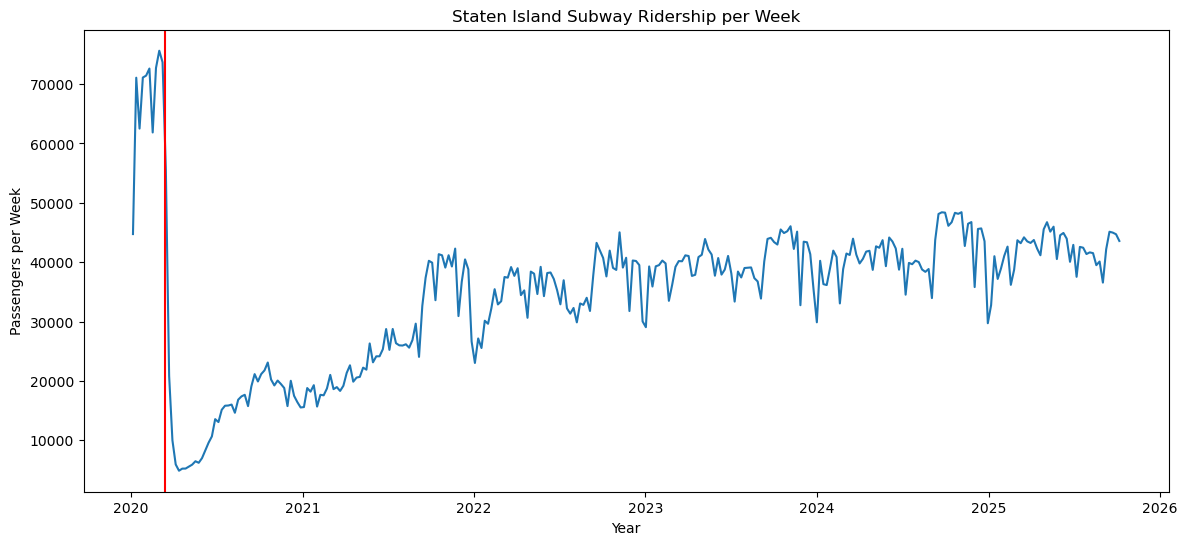

In [60]:
plt.figure(figsize=(14,6))
plt.plot(ridership_by_week[:-2])
plt.title('Staten Island Subway Ridership per Week')
plt.xlabel('Year')
plt.ylabel('Passengers per Week')
plt.axvline(x = pd.Timestamp('2020-03-15'), color='red')
plt.show()

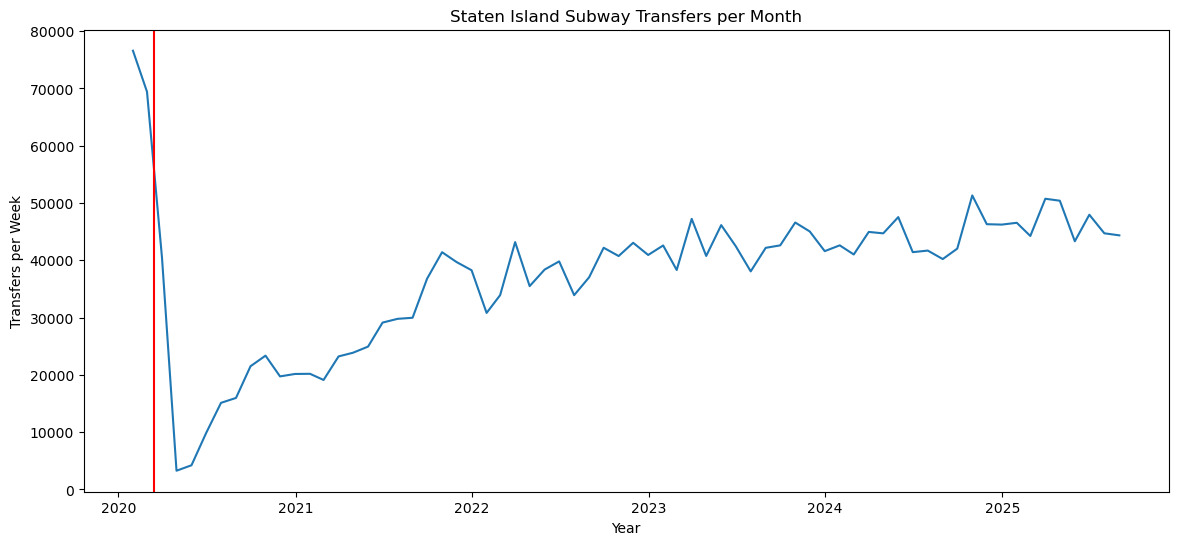

In [61]:
plt.figure(figsize=(14,6))
plt.plot(transfers_by_month[:-2])
plt.title('Staten Island Subway Transfers per Month')
plt.xlabel('Year')
plt.ylabel('Transfers per Week')
plt.axvline(x = pd.Timestamp('2020-03-15'), color='red')
plt.show()

# Time in Digital Audio - Playing a Drum Pattern with `time.sleep()`

## The `pygame` Module

Python is by *far* not the best programming language for game design, but the `pygame` module still has some useful features for creating user interfaces, including an audio mixer.

In [62]:
## Initialize the mixer:

pygame.mixer.init()

## The Winstons - "Amen, Brother"

In the "Amen" folder, there are a selection of `.wav` files, all individual drum hits from the first measure of a famous drum solo by Gregory C. Coleman of [The Winstons](https://en.wikipedia.org/wiki/The_Winstons), on a 1969 track called "Amen, Brother".

This short, mid-song drum solo, (often called a "break" or "breakbeat" since it takes place during a break in other instrumentation) is one of the most-sampled music recordings of all time. Whether or not you're aware of it, you've probably heard it before. It has spawned entire genres of electronic music.

Neither Gregory Coleman nor any of the other Winstons members ever received royalties for the drum loop's use in *thousands* of published works of music.

* ***If you care to dive down a rabbit hole about music culture, sampling, intellectual property, and the public domain, [Nate Harrison's video essay "Can I Get an Amen?" from 2004](https://www.youtube.com/watch?v=XPoxZW8JzzM) is worth a watch.***

## Drum Samples

In [63]:
kick1 = 'Amen/Amen 1-1 (Kick).wav'
kick2 = 'Amen/Amen 1-2 (Kick).wav'
snare1 = 'Amen/Amen 1-3 (Snare).wav'
hat1 = 'Amen/Amen 1-4a (Hat).wav'
snarelite1 =  'Amen/Amen 1-4b (Snarelite).wav'
hat2 = 'Amen/Amen 1-5a (Hat).wav'
snarelite2 = 'Amen/Amen 1-5b (Snarelite).wav'
kickride = 'Amen/Amen 1-6a (Kickride).wav'
kick3 = 'Amen/Amen 1-6b (Kick).wav'
snare2 = 'Amen/Amen 1-7 (Snare).wav'
hat3 = 'Amen/Amen 1-8a (Hat).wav'
snarelite3 = 'Amen/Amen 1-8b (Snarelite).wav'

In [64]:
pygame.mixer.music.load(snare1)
pygame.mixer.music.play()

### Note Values

If you've never dealt with music theory before, don't worry about this too much, but most music is divided into short segments called "measures" that contain a specified number of beats (regularly-spaced rhythmic pulses). A "4/4" time signature or "Common time" as it is sometimes called represents four beats to a measure, each with a value of a "quarter note". The rhythm is felt in groups of four.

Tempo is a measure of how many beats there are in a given time period. In the original sample from "Amen, Brother", the tempo is a little under 140 beats per minute. We're going to use 140 as a starting point.

Since each beat in 4/4 time is a quarter note, we can divide 60 by the beats per minute to get the duration of a quarter note, and then subdivide further for eighth notes, sixteenth notes, etc.

In [65]:
# Define beats per minute
bpm = 140

# Define length in seconds for each note value
half = 30 / bpm
quarter = 60 / bpm
eighth = 60 / bpm / 2
sixteenth = 60 / bpm / 4
thirtysecond = 60 / bpm / 8
sixtyfourth = 60 / bpm / 16

In [66]:
eighth

0.21428571428571427

In [67]:
sixteenth

0.10714285714285714

An eighth note (half of a quarter note, or half of a "beat" in 4/4 time) played at a tempo of 140 beats per minute is ~0.21429 seconds long. A sixteenth note is ~0.10714 seconds. If we know these note values, we can send them to `time.sleep()` to instruct Python to wait after playing a sample for that duration before playing the next sample.

This lets us play the audio samples at a consistent tempo, even accounting for different note values.

In [68]:
def play_sample(sample, duration=eighth):
    pygame.mixer.music.load(sample)
    pygame.mixer.music.play()
    print(sample)
    time.sleep(duration)

In [69]:
def play_measure(samples, durations):
    for sample, duration in zip(samples, durations):
        play_sample(sample, duration)

In [70]:
# 1 measure
# 4 eighth notes and 8 sixteenth notes comprise a full measure... just add up the fractions!
# The snare drums fall on the 2nd and 4th quarter notes of the measure

samples = [
    kick1,
    kick2, 
    snare1, 
    hat1, snarelite1, 
    hat2, snarelite2, 
    kickride, kick3, 
    snare2, 
    hat3, snarelite3
]

durations = [
    eighth, 
    eighth, 
    eighth, 
    sixteenth, sixteenth, 
    sixteenth, sixteenth,
    sixteenth, sixteenth,
    eighth, 
    sixteenth, sixteenth]

In [71]:
for i in range(4):
    play_measure(samples, durations)

Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-2 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-4b (Snarelite).wav
Amen/Amen 1-5a (Hat).wav
Amen/Amen 1-5b (Snarelite).wav
Amen/Amen 1-6a (Kickride).wav
Amen/Amen 1-6b (Kick).wav
Amen/Amen 1-7 (Snare).wav
Amen/Amen 1-8a (Hat).wav
Amen/Amen 1-8b (Snarelite).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-2 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-4b (Snarelite).wav
Amen/Amen 1-5a (Hat).wav
Amen/Amen 1-5b (Snarelite).wav
Amen/Amen 1-6a (Kickride).wav
Amen/Amen 1-6b (Kick).wav
Amen/Amen 1-7 (Snare).wav
Amen/Amen 1-8a (Hat).wav
Amen/Amen 1-8b (Snarelite).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-2 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-4b (Snarelite).wav
Amen/Amen 1-5a (Hat).wav
Amen/Amen 1-5b (Snarelite).wav
Amen/Amen 1-6a (Kickride).wav
Amen/Amen 1-6b (Kick).wav
Amen/Amen 1-7 (Snare).wav
Amen/Amen 1-8a (Hat).wav
Amen/Amen 1-8b (Snarelite).wav
Amen/Amen 1-1 (Kick).w

### "Swing Time"

To change the rhythmic feel, or "groove", you can mimic swing time or swung rhythm by changing the times of sixteenth notes depending on where they fall in the measure. A sixteenth note that lines up with eighth-note subdivisions will be slightly longer in duration, but a sixteenth note that falls off of an eighth-note subdivision will have a shorter duration.

In [72]:
swing = 0.15

sixteenth * (1+swing)+ sixteenth * (1-swing)

0.21428571428571425

In [73]:
eighth

0.21428571428571427

In [74]:
# 1 measure

swing = 0.15

samples = [
    kick1,
    kick2, 
    snare1, 
    hat1, snarelite1, 
    hat2, snarelite2, 
    kickride, kick3, 
    snare2, 
    hat3, snarelite3
]

durations = [
    eighth, 
    eighth, 
    eighth, 
    sixteenth * (1+swing), sixteenth * (1-swing), 
    sixteenth * (1+swing), sixteenth * (1-swing),
    sixteenth * (1+swing), sixteenth * (1-swing),
    eighth, 
    sixteenth * (1+swing), sixteenth * (1-swing)]

In [75]:
for i in range(4):
    play_measure(samples, durations)

Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-2 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-4b (Snarelite).wav
Amen/Amen 1-5a (Hat).wav
Amen/Amen 1-5b (Snarelite).wav
Amen/Amen 1-6a (Kickride).wav
Amen/Amen 1-6b (Kick).wav
Amen/Amen 1-7 (Snare).wav
Amen/Amen 1-8a (Hat).wav
Amen/Amen 1-8b (Snarelite).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-2 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-4b (Snarelite).wav
Amen/Amen 1-5a (Hat).wav
Amen/Amen 1-5b (Snarelite).wav
Amen/Amen 1-6a (Kickride).wav
Amen/Amen 1-6b (Kick).wav
Amen/Amen 1-7 (Snare).wav
Amen/Amen 1-8a (Hat).wav
Amen/Amen 1-8b (Snarelite).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-2 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-4b (Snarelite).wav
Amen/Amen 1-5a (Hat).wav
Amen/Amen 1-5b (Snarelite).wav
Amen/Amen 1-6a (Kickride).wav
Amen/Amen 1-6b (Kick).wav
Amen/Amen 1-7 (Snare).wav
Amen/Amen 1-8a (Hat).wav
Amen/Amen 1-8b (Snarelite).wav
Amen/Amen 1-1 (Kick).w

### Programming Exercise - Drum Programming

Try programming your own drum loop!

In [76]:
################################################################################
################################################################################

samples = [
    kick1,
    snare1,
    kick1,
    snare1
]

durations = [
    quarter,
    quarter,
    quarter,
    quarter
]

for i in range(4):
    play_measure(samples, durations)
################################################################################
################################################################################

Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-3 (Snare).wav


## Jungle/Drum'n'Bass

The Winstons' drum sample became the basis for several genres of electronic music by virtue of its rhythmic feel and distinct timbre. In the early 1990s, the sample was used extensivley by music producers in the Carribean and the U.K. in fast-paced dance music that chopped up the beat and played with its syncopation.

In [77]:
# Define beats per minute
bpm = 176

# Define note lengths
half = 30 / bpm
quarter = 60 / bpm
eighth = 60 / bpm / 2
sixteenth = 60 / bpm / 4
thirtysecond = 60 / bpm / 8
sixtyfourth = 60 / bpm / 16

In [78]:
# Measures 1 & 3

samples1 = [
    kick1,
    hat1, hat2,
    snare1, 
    kick1,
    hat1, snarelite1,
    snare1,
    kick1, 
    kick2
]

durations1 = [
    eighth, 
    sixteenth, sixteenth,
    eighth, 
    eighth, 
    sixteenth, sixteenth,
    eighth, 
    eighth, 
    eighth]

In [79]:
# Measure 2

samples2 = [
    kick1,
    hat1, hat2,
    snare1, 
    kick1,
    hat1, snarelite1,
    snare1,
    kick1, snarelite1,
    snare2
]

durations2 = [
    eighth, 
    sixteenth, sixteenth,
    eighth, 
    eighth, 
    sixteenth, sixteenth,
    eighth, 
    sixteenth, sixteenth, 
    eighth]

In [80]:
# Measure 4

samples3 = [
    kick1,
    hat1, hat2,
    snare1, 
    hat1, snarelite1,
    hat2, snarelite2,
    kick1,
    snare1, snare2,
    snare1, snare2
]

durations3 = [
    eighth, 
    sixteenth, sixteenth,
    eighth, 
    sixteenth, sixteenth, 
    sixteenth, sixteenth,
    eighth, 
    sixteenth, sixteenth, 
    sixteenth, sixteenth]

In [81]:
play_measure(samples1, durations1)
play_measure(samples2, durations2)
play_measure(samples1, durations1)
play_measure(samples3, durations3)
play_sample(kick1, eighth)

Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-5a (Hat).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-4b (Snarelite).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-2 (Kick).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-5a (Hat).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-4b (Snarelite).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-4b (Snarelite).wav
Amen/Amen 1-7 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-5a (Hat).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-4b (Snarelite).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-2 (Kick).wav
Amen/Amen 1-1 (Kick).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-5a (Hat).wav
Amen/Amen 1-3 (Snare).wav
Amen/Amen 1-4a (Hat).wav
Amen/Amen 1-4b (Snarelite).wav
Amen/Amen 1-5a (Hat).wav
Amen/Amen 1-

Using dedicated Digital Audio Workstation software like GarageBand, FL Studio, Reason, Cubase, Live, Logic, or even ProTools is likely an easier route to producing music, but if you really like building things from scratch, Python can work, too!